Train on 5515 samples, validate on 1227 samples
Epoch 1/5
5515/5515 [==============================] - 2s 289us/step - loss: 21.0359 - val_loss: 6.5345
Epoch 2/5
5515/5515 [==============================] - 1s 122us/step - loss: 4.1264 - val_loss: 2.5639
Epoch 3/5
5515/5515 [==============================] - 1s 119us/step - loss: 1.9100 - val_loss: 1.4541
Epoch 4/5
5515/5515 [==============================] - 1s 119us/step - loss: 1.1663 - val_loss: 0.9283
Epoch 5/5
5515/5515 [==============================] - 1s 119us/step - loss: 0.7659 - val_loss: 0.6280


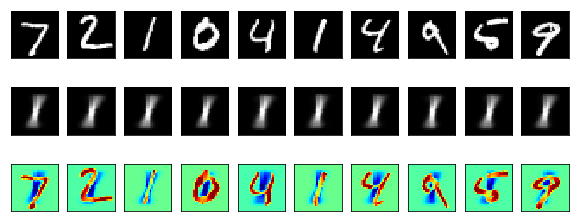

In [2]:
from keras.layers import Input, Dense, Lambda, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import mnist
from keras.losses import binary_crossentropy
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import cv2

latent_dim = 32
batch_size = 64
img_size = 28
epochs = 5

# encoder
input_img = Input(shape=(img_size, img_size, 1))
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# 潜在変数
z_mean = Dense(latent_dim, name='z_mean')(encoded)
z_log_var = Dense(latent_dim, name='z_log_var')(encoded)

def sampling(args):
    z_mean, z_log_var = args
    latent_dim = 32
    epsilon_std = 1.0
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0],
                                     K.shape(z_mean)[1],
                                     K.shape(z_mean)[2],
                                     latent_dim),
                              mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

z = Lambda(sampling)([z_mean, z_log_var])

# decoder
x = Conv2D(16, (3, 3), activation='relu', padding='same')(z)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# autoencoderの定義
autoencoder = Model(input_img, decoded)

# loss関数
# Compute VAE loss
xent_loss = K.mean(metrics.binary_crossentropy(input_img, decoded), axis=-1)
kl_loss =  - 0.5 * K.mean(K.sum(1 + K.log(K.square(z_log_var)) - K.square(z_mean) - K.square(z_log_var), axis=-1))
vae_loss = K.mean(xent_loss + kl_loss)

autoencoder.add_loss(vae_loss)
autoencoder.compile(optimizer='adam')

# MNISTデータを前処理する
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train,test_size=0.175)
# 正規化する
x_train = x_train.astype('float32')/255.
x_valid = x_valid.astype('float32')/255.
x_test = x_test.astype('float32')/255.
x_train = np.reshape(x_train, (len(x_train), img_size, img_size, 1))
x_valid = np.reshape(x_valid, (len(x_valid), img_size, img_size, 1))
x_test = np.reshape(x_test, (len(x_test), img_size, img_size, 1))

# 学習に使うデータを1に限定する
x_train = x_train[y_train==1]
x_valid = x_valid[y_valid==1]

# autoencoderの実行
autoencoder.fit(x_train,
                epochs=epochs,
                batch_size=batch_size,
                validation_data=(x_valid, None))

# 実行結果の表示
n = 10
decoded_imgs = autoencoder.predict(x_test[:n])

plt.figure(figsize=(10, 4))
for i in range(n):
    # original_image
    orig_img = x_test[i].reshape(img_size, img_size)

    # reconstructed_image
    reconst_img = decoded_imgs[i].reshape(img_size, img_size)

    # diff image
    diff_img = ((orig_img - reconst_img)+2)/4
    diff_img = (diff_img*255).astype(np.uint8)
    orig_img = (orig_img*255).astype(np.uint8)
    reconst_img = (reconst_img*255).astype(np.uint8)
    diff_img_color = cv2.applyColorMap(diff_img, cv2.COLORMAP_JET)

    # display original
    ax = plt.subplot(3, n,  i + 1)
    plt.imshow(orig_img, cmap=plt.cm.gray)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(3, n, i + n + 1)
    plt.imshow(reconst_img, cmap=plt.cm.gray)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display diff
    ax = plt.subplot(3, n, i + n*2 + 1)
    plt.imshow(diff_img, cmap=plt.cm.jet)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# 学習結果の保存
autoencoder.save('./ae_mnist.h5')

# json and weights
model_json = autoencoder.to_json()
with open('ae_mnist.json', 'w') as json_file:
    json_file.write(model_json)
autoencoder.save_weights('ae_mnist_weights.h5')

## load model
#from keras.models import model_from_json
#
## load model.json
#json_file = open('vcae_mnist.json', 'r')
#loaded_model_json = json_file.read()
#json_file.close()
#
#loaded_model = model_from_json(loaded_model_json)
#
## load weights into new model
#loaded_model.load_weights('vcae_mnist_weights.h5')
#
## Compute VAE loss
#xent_loss = K.mean(metrics.binary_crossentropy(input_img, decoded), axis=-1)
#kl_loss =  - 0.5 * K.mean(K.sum(1 + K.log(K.square(z_log_var)) - K.square(z_mean) - K.square(z_log_var), axis=-1))
#vae_loss = K.mean(xent_loss + kl_loss)
#
#loaded_model.add_loss(vae_loss)
#loaded_model.compile(optimizer=opt)